Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Luan Van/')

In [ ]:
pip install transformers datasets evaluate sacrebleu rouge_score accelerate sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=951b7fca0fda804e18803a976d94c385f3b95738c91fd176a0ac4dec7135497f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
  Attempting uninsta

Dataset download and filter

In [ ]:
import datasets
from datasets import load_dataset

dataset = datasets.load_dataset("mbien/recipe_nlg", data_dir="recipenlg_dataset/dataset")
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.11k [00:00<?, ?B/s]

recipe_nlg.py:   0%|          | 0.00/4.43k [00:00<?, ?B/s]

The repository for mbien/recipe_nlg contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mbien/recipe_nlg.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/2231142 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'ingredients', 'directions', 'link', 'source', 'ner'],
        num_rows: 2231142
    })
})


In [ ]:
dataset['train'][1]

{'id': 1,
 'title': "Jewell Ball'S Chicken",
 'ingredients': ['1 small jar chipped beef, cut up',
  '4 boned chicken breasts',
  '1 can cream of mushroom soup',
  '1 carton sour cream'],
 'directions': ['Place chipped beef on bottom of baking dish.',
  'Place chicken on top of beef.',
  'Mix soup and cream together; pour over chicken. Bake, uncovered, at 275° for 3 hours.'],
 'link': 'www.cookbooks.com/Recipe-Details.aspx?id=699419',
 'source': 0,
 'ner': ['beef', 'chicken breasts', 'cream of mushroom soup', 'sour cream']}

In [ ]:
print(gen_text)

Generate recipe from these ingredients: beef, chicken breasts, cream of mushroom soup, sour cream. Add some cream of mushroom soup and enjoy!<|endoftext|>


In [ ]:
# Target ingredients
target_ingredients = ['apple', 'banana', 'beef', 'blueberries', 'bread', 'butter',
                      'carrot', 'cheese', 'chicken', 'chicken_breast', 'chocolate',
                      'corn', 'eggs', 'flour', 'goat_cheese', 'green_beans',
                      'ground_beef', 'ham', 'heavy_cream', 'lime', 'milk', 'mushrooms',
                      'onion', 'potato', 'shrimp', 'spinach', 'strawberries', 'sugar',
                      'sweet_potato', 'tomato']

In [ ]:
def contains_target_ingredient(example):
    # Count the number of target ingredients in the 'ner' field
    count = sum(1 for ingredient in target_ingredients if ingredient in example['ner'])
    # Return True if the count is 4 or more
    return count >= 4

# Apply the filter to both train and test splits
dataset = dataset.filter(contains_target_ingredient)
print(dataset)

Filter:   0%|          | 0/2231142 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'ingredients', 'directions', 'link', 'source', 'ner'],
        num_rows: 164070
    })
})


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("google/t5-v1_1-base")

# Add the padding token to the tokenizer
# tokenizer.pad_token = tokenizer.eos_token  # Use the EOS token as the padding token


def filter_long_recipes(example):
    """Filters out recipes with outputs exceeding 512 tokens."""
    ingredients = ", ".join(example["ner"])
    input_text = f"Generate recipe from these ingredients: {ingredients}"
    output_text = f"Title: {example['title']}\nIngredients: {ingredients}\nInstructions: {example['directions']}"

    # Tokenize the output text and check its length
    tokenized_output = tokenizer(output_text, truncation=False)  # Don't truncate for length check

    return len(tokenized_output["input_ids"]) <= 512


# Apply the filter to the dataset
filtered_dataset = dataset.filter(filter_long_recipes)

Filter:   0%|          | 0/164070 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (957 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
print(filtered_dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'ingredients', 'directions', 'link', 'source', 'ner'],
        num_rows: 155106
    })
})


In [ ]:
# Save filtered data
save_directory = "./filtered_recipe_data"  # Replace with your desired directory
filtered_dataset.save_to_disk(save_directory)


Saving the dataset (0/1 shards):   0%|          | 0/155106 [00:00<?, ? examples/s]

Load Filtered Dataset

In [ ]:
from datasets import load_from_disk, DatasetDict

# Load the filtered dataset from the directory where it was saved
filtered_dataset = load_from_disk("./filtered_recipe_data")  # Replace with your save directory

# Now you can work with the filtered_dataset
print(filtered_dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'ingredients', 'directions', 'link', 'source', 'ner'],
        num_rows: 155106
    })
})


In [ ]:
filtered_dataset = filtered_dataset['train'].train_test_split(test_size=0.45, seed=2)

In [ ]:
filtered_dataset = filtered_dataset['train']

In [ ]:
filtered_dataset[0]

{'id': 41,
 'title': 'Quick Coffee Cake(6 Servings)  ',
 'ingredients': ['3 Tbsp. softened butter or margarine',
  '1/2 c. granulated sugar',
  '1 egg',
  '1 c. flour',
  '1 1/4 tsp. baking powder',
  '1/4 tsp. salt',
  '1/3 c. milk',
  '1/4 tsp. vanilla',
  '1/3 c. brown sugar, packed',
  '1/2 tsp. cinnamon',
  '2 Tbsp. butter or margarine'],
 'directions': ['Mix 3 tablespoons fat with granulated sugar.',
  'Add egg and beat until creamy.',
  'Mix flour, baking powder and salt thoroughly.',
  'Add to sugar mixture alternately with milk.',
  'Add vanilla. Spread batter evenly in a greased 8-inch square baking pan.',
  'Mix brown sugar and cinnamon and sprinkle over batter.',
  'Dot with 2 tablespoons fat.',
  'Bake at 350° (moderate oven) for 25 to 30 minutes.'],
 'link': 'www.cookbooks.com/Recipe-Details.aspx?id=532166',
 'source': 0,
 'ner': ['butter',
  'sugar',
  'egg',
  'flour',
  'baking powder',
  'salt',
  'milk',
  'vanilla',
  'brown sugar',
  'cinnamon',
  'butter']}

In [ ]:
columns_to_remove = ['id', 'link', 'source']
filtered_dataset = filtered_dataset.remove_columns(columns_to_remove)

In [ ]:
filtered_dataset = filtered_dataset.train_test_split(test_size=0.1, seed=2)

In [ ]:
print(filtered_dataset)

DatasetDict({
    train: Dataset({
        features: ['title', 'ingredients', 'directions', 'ner'],
        num_rows: 76777
    })
    test: Dataset({
        features: ['title', 'ingredients', 'directions', 'ner'],
        num_rows: 8531
    })
})


In [ ]:
# Save filtered data
save_directory = "./filtered_recipe_data2"  # Replace with your desired directory
filtered_dataset.save_to_disk(save_directory)

Saving the dataset (0/1 shards):   0%|          | 0/76777 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/8531 [00:00<?, ? examples/s]

Train (xài A100, T4 k đủ memory)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer, TrainingArguments

# 1. Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google/t5-v1_1-base")

# Add the padding token to the tokenizer
# tokenizer.pad_token = tokenizer.eos_token  # Use the EOS token as the padding token

model = AutoModelForSeq2SeqLM.from_pretrained("google/t5-v1_1-base")

# 2. Prepare the dataset
def format_data(example):
    ingredients = ", ".join(example["ner"])
    input_text = f"Generate recipe from these ingredients: {ingredients}"
    output_text = f"Title: {example['title']}\nIngredients: {ingredients}\nInstructions: {example['directions']}"
    return {"input_text": input_text, "output_text": output_text}

formatted_dataset = filtered_dataset.map(format_data)

def tokenize_function(examples):
    inputs = tokenizer(examples["input_text"], padding="max_length", truncation=True, max_length=128)
    outputs = tokenizer(examples["output_text"], padding="max_length", truncation=True, max_length=512)
    inputs["labels"] = outputs["input_ids"]  # Set labels for training
    return inputs

tokenized_datasets = formatted_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/pyth

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model="google/t5-v1_1-base")

In [ ]:
import torch
# 3. Define training arguments
training_args = TrainingArguments(
    output_dir="./t5_results",
    eval_strategy="steps",
    eval_steps=500,
    logging_dir="./logs",
    logging_steps=500,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=1,
)

# import evaluate

# def compute_metrics(eval_pred):
#     """Computes BLEU and ROUGE metrics in batches."""
#     bleu = evaluate.load("bleu")
#     rouge = evaluate.load("rouge")

#     predictions, labels = eval_pred

#     # Calculate metrics in batches to reduce memory usage
#     batch_size = 4  # Reduced batch size for evaluation
#     num_batches = len(predictions) // batch_size + (len(predictions) % batch_size > 0)

#     bleu_scores = []
#     rouge_scores = []

#     for i in range(num_batches):
#         start_idx = i * batch_size
#         end_idx = min((i + 1) * batch_size, len(predictions))

#         # Detach from GPU and move to CPU before decoding, also free memory immediately
#         batch_preds = tokenizer.batch_decode(predictions[start_idx:end_idx].cpu().detach(), skip_special_tokens=True)
#         batch_labels = tokenizer.batch_decode(labels[start_idx:end_idx].cpu().detach(), skip_special_tokens=True)

#         # Clear cache after each batch
#         if torch.cuda.is_available():
#             torch.cuda.empty_cache()

#         bleu_scores.append(bleu.compute(predictions=batch_preds, references=batch_labels)["bleu"])
#         rouge_result = rouge.compute(predictions=batch_preds, references=batch_labels, use_stemmer=True)
#         rouge_scores.append(np.mean([rouge_result["rouge1"], rouge_result["rouge2"], rouge_result["rougeL"]]))

#     # Return the average of the batch scores
#     return {"bleu": np.mean(bleu_scores), "rouge": np.mean(rouge_scores)}



# 4. Create the Trainer and train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    data_collator=data_collator,
    # compute_metrics=compute_metrics
)


NameError: name 'model' is not defined

In [ ]:
tokenized_datasets['train'][0]

{'title': 'Swedish Meatballs',
 'ingredients': ['2 1/2 lb. ground beef',
  '4 eggs',
  '1 c. bread crumbs',
  '1 c. minced onions',
  '1 c. half and half cream',
  '2 c. milk',
  '1/4 c. butter',
  '3 tsp. salt',
  '1/4 tsp. allspice',
  '1/4 c. flour',
  '3 c. beef stock',
  '1 tsp. dill weed'],
 'directions': ['Beat eggs slightly Add milk and bread crumbs; let stand.',
  'Saute onions in 2 tablespoons butter.',
  'Remove and add to crumb mix.',
  'Add seasonings and meat; mixture will be soft.',
  'Chill 1 hour to blend flavors.',
  'Shape mixture into 1 to 1 1/2-inch balls and brown slowly in remaining butter, turning easily.',
  'Add more butter if necessary. Arrange in large baking dish.',
  'Add flour to pan drippings and blend.',
  'Cook until browned.',
  'Add beef broth and simmer until thickened and smooth.',
  'Add cream.',
  'Sauce will be thin.',
  'Pour over meatballs.',
  'Bake at 325° in oven for 30 to 45 minutes.'],
 'ner': ['ground beef',
  'eggs',
  'bread crumbs',
 

In [ ]:
# Force model weights to be contiguous before training
for name, param in model.named_parameters():
    if not param.is_contiguous():
        param.data = param.data.contiguous()
# Train the model
trainer.train()

Step,Training Loss,Validation Loss
500,1.031700,0.800840
1000,0.960900,0.760672
1500,0.896600,0.732553
2000,0.873700,0.712537
2500,0.847100,0.699229
3000,0.837900,0.690442


Step,Training Loss,Validation Loss
500,1.031700,0.800840
1000,0.960900,0.760672
1500,0.896600,0.732553
2000,0.873700,0.712537
2500,0.847100,0.699229
3000,0.837900,0.690442
3500,0.823900,0.685021
4000,0.831200,0.681507


TrainOutput(global_step=4456, training_loss=0.8796424523290227, metrics={'train_runtime': 3878.0015, 'train_samples_per_second': 18.384, 'train_steps_per_second': 1.149, 'total_flos': 1.2204601482018816e+16, 'train_loss': 0.8796424523290227, 'epoch': 1.0})

In [ ]:
# Log history
with open("t5v1.1_log.txt", "w") as outfile:
  outfile.write(f"{trainer.state.log_history}\n")
outfile.close()

In [ ]:
# Make sure all tensors in the model state_dict are contiguous before saving
for name, param in model.state_dict().items():
    if not param.is_contiguous():
        model.state_dict()[name] = param

trainer.save_model("./trained_t5v1.1_recipe_generator")
# Save the tokenizer
tokenizer.save_pretrained("./trained_t5v1.1_recipe_generator")

('./trained_t5v1.1_recipe_generator/tokenizer_config.json',
 './trained_t5v1.1_recipe_generator/special_tokens_map.json',
 './trained_t5v1.1_recipe_generator/spiece.model',
 './trained_t5v1.1_recipe_generator/added_tokens.json',
 './trained_t5v1.1_recipe_generator/tokenizer.json')

resume training

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer, TrainingArguments

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/t5-v1_1-base")
model = AutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/Colab Notebooks/Luan Van/t5_results/checkpoint-3500")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# 2. Prepare the dataset
def format_data(example):
    ingredients = ", ".join(example["ner"])
    input_text = f"Generate recipe from these ingredients: {ingredients}"
    output_text = f"Title: {example['title']}\nIngredients: {ingredients}\nInstructions: {example['directions']}"
    return {"input_text": input_text, "output_text": output_text}

formatted_dataset = filtered_dataset.map(format_data)

def tokenize_function(examples):
    inputs = tokenizer(examples["input_text"], padding="max_length", truncation=True, max_length=128)
    outputs = tokenizer(examples["output_text"], padding="max_length", truncation=True, max_length=512)
    inputs["labels"] = outputs["input_ids"]  # Set labels for training
    return inputs

tokenized_datasets = formatted_dataset.map(tokenize_function, batched=True)

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model="google/t5-v1_1-base")

In [ ]:
import torch
# 3. Define training arguments
training_args = TrainingArguments(
    output_dir="./t5_results",
    eval_strategy="steps",
    eval_steps=500,
    logging_dir="./logs",
    logging_steps=500,
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=1,
)
# 4. Create the Trainer and train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    data_collator=data_collator,
    # compute_metrics=compute_metrics
)

In [ ]:
trainer.train(resume_from_checkpoint="/content/drive/MyDrive/Colab Notebooks/Luan Van/t5_results/checkpoint-3500")


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].
/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2833: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on

Step,Training Loss,Validation Loss
4000,0.827000,0.675180


TrainOutput(global_step=4456, training_loss=0.17420112979690305, metrics={'train_runtime': 764.9018, 'train_samples_per_second': 93.205, 'train_steps_per_second': 5.826, 'total_flos': 1.2204601482018816e+16, 'train_loss': 0.17420112979690305, 'epoch': 1.0})

Inference

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_from_disk

# Load your trained model and tokenizer
model_path = "./trained_t5v1.1_recipe_generator"  # Replace with your model name or path
model_trained = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained("./trained_t5v1.1_recipe_generator")

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [ ]:
# Function to generate text
def generate_text(input_text):
    inputs = tokenizer(input_text, return_tensors="pt", padding=True)
    # Set max_new_tokens to control the generated sequence length
    # outputs = model_trained.generate(**inputs, num_beams=5, no_repeat_ngram_size=2)  # Adjust as needed
    outputs = model_trained.generate(**inputs, max_new_tokens=512, num_beams=2, no_repeat_ngram_size=2, repetition_penalty=1.2)  # Adjust as needed

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text


In [ ]:
# Load the preprocessed dataset (replace with your dataset path)
filtered_dataset = load_from_disk("./filtered_recipe_data2")

# Generate examples from the test set
num_examples = 5  # Number of examples to generate
for i in range(num_examples):
    ingredients = ", ".join(filtered_dataset["train"][i]["ner"])
    input_text = f"Generate recipe from these ingredients: {ingredients}"
    generated_text = generate_text(input_text)
    print(f"Input: {input_text}")
    print(f"Generated Text: {generated_text}\n")

Input: Generate recipe from these ingredients: butter, sugar, egg, flour, baking powder, salt, milk, vanilla, brown sugar, cinnamon, butter
Generated Text: Title: Cinnamon Brownies Ingredients: butter, sugar, egg, flour, baking powder, salt, milk, vanilla, brown sugar cinnamon, butter Instructions ['Preheat oven to 350 degrees F.', 'In a large bowl, cream butter and sugar until light and fluffy. Add eggs, one at time, beating well after each addition. Beat in vanilla and cinnamon. Stir in milk and vanilla. Mix well. Pour into greased and floured 9 x 13-inch pan. Bake at 350° for 45 minutes or until golden brown. Remove from pan and cool completely. Cool in pan for 10 minutes, then remove from heat and let cool for 5 minutes. Serve warm or warm with ice creame cream and whipped cream. Sprinkle with cinnamon and butter. Cut into squares and bake for 30 minutes at 325°F for 20 minutes before serving. Let cool in refrigerator for 1 hour.

Input: Generate recipe from these ingredients: marg

In [ ]:
# Run inference on a new input
new_input = "Generate recipe from these ingredients: apple, banana, beef, blueberries"
generated_text = generate_text(new_input)
print(f"New Input: {new_input}")
print(f"Generated Text: {generated_text}")

New Input: Generate recipe from these ingredients: apple, banana, beef, blueberries
Generated Text: Title: Apple Banana Bread Ingredients: apple, banana, beef, blueberries Instructions ['Preheat oven to 350°.', 'Mix all ingredients together and add to apple mixture. Add beef and mix well. Serve with blueberry sauce. Bake at 400° for 30 minutes. Remove from oven and serve with berries and whipped cream. Sprinkle with remaining ingredients. Cover and refrigerate for 1 hour or until golden brown. Cool in refrigerator. Transfer to a greased 9 x 13-inch baking dish. Place in oven for 10 minutes or till golden. Let cool for 5 minutes before serving. Cut into squares and bake at 350 degrees for 20 minutes, until browned and brown on top. Cook for 15 minutes until brown and golden and crisp. Turn to wire racks. Top with cheese and remaining apples. Spread over top of the top and top with the remaining apple slices of apple. Spoon the apples and the apple and beef. Stir in the beef mixture, and

In [ ]:
input1 = "butter, green beans, spinach, onion, sweet potato, mushrooms, heavy cream, ground beef, eggs, sweet potato, bread, strawberries"
input2 = "sugar, chocolate, sugar, carrot, bread, apple, ground beef, tomato, green beans, flour, strawberries, lime"
input3 = "spinach, sugar, chicken, tomato, apple, chicken breast, carrot, strawberries, bread, ground beef, lime, beef, beef"
input4 = "chicken breast, eggs, bread, onion, apple, chocolate, spinach, tomato, blueberries, strawberries, sweet potato, sugar"
input_list = [input1,input2,input3,input4]

In [ ]:
for input_str in input_list:
  # Format the input
  formatted_input = f"Generate recipe from these ingredients: {input_str}"

  # Generate the recipe
  generated_recipe = generate_text(formatted_input)

  # Print the results
  print(f"Input Ingredients: {input_str}\n")
  print(f"Generated Recipe:\n{generated_recipe}\n\n")


Input Ingredients: butter, green beans, spinach, onion, sweet potato, mushrooms, heavy cream, ground beef, eggs, sweet potato, bread, strawberries

Generated Recipe:
Title: Sweet Potato And Spinach Soup Ingredients: butter, green beans, spinach, onion, sweet potato, mushrooms, heavy cream, ground beef, eggs, Sweet potato Instructions ['Preheat oven to 350 degrees F.', 'In a large skillet, melt butter and green bean in butter until tender. Add spinach and onion; saute for 5 minutes. Stir in mushrooms and cook until soft. Remove from heat and stir in remaining ingredients. Pour into greased 9 x 13-inch baking dish. Bake at 350° for 30 minutes or until golden brown. Cool on wire rack. Serve warm with whipped cream and strawberries. Sprinkle with bread. Place in pan and bake for 20 minutes, or till golden. Cut into squares. Cover and refrigerate for 1 hour. Let stand for 10 minutes before serving. Top with remaining cheese and sliced strawberries and top with fresh fruit. Spread over top o

In [ ]:
os.listdir()

['yolo11m.onnx',
 'YOLO_results',
 'datasets',
 'data.yaml',
 'results',
 'test example',
 'YOLOv11m.ipynb',
 'datasets_augmented',
 'yolo11m.pt',
 'YOLO_results_2',
 'yolo11n.pt',
 'data2.yaml',
 'plotting',
 'recipenlg_dataset',
 'train 2 YOLOv11m.ipynb',
 'filtered_recipe_data',
 'logs',
 't5v1.1_log.txt',
 't5_results',
 'trained_t5v1.1_recipe_generator',
 'T5v11.ipynb']

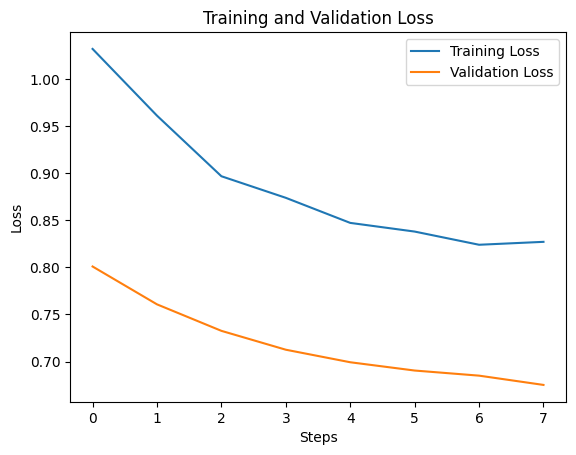

In [ ]:
import matplotlib.pyplot as plt
import json

log_history = [{'epoch': 0.11220825852782765, 'grad_norm': 0.25569310784339905, 'learning_rate': 1.7755834829443448e-05, 'loss': 1.0317, 'step': 500}, {'epoch': 0.11220825852782765, 'eval_loss': 0.8008396029472351, 'eval_runtime': 105.0134, 'eval_samples_per_second': 75.438, 'eval_steps_per_second': 4.723, 'step': 500}, {'epoch': 0.2244165170556553, 'grad_norm': 0.27898725867271423, 'learning_rate': 1.5511669658886893e-05, 'loss': 0.9609, 'step': 1000}, {'epoch': 0.2244165170556553, 'eval_loss': 0.760672390460968, 'eval_runtime': 104.8814, 'eval_samples_per_second': 75.533, 'eval_steps_per_second': 4.729, 'step': 1000}, {'epoch': 0.33662477558348297, 'grad_norm': 0.2408847063779831, 'learning_rate': 1.3267504488330343e-05, 'loss': 0.8966, 'step': 1500}, {'epoch': 0.33662477558348297, 'eval_loss': 0.7325534224510193, 'eval_runtime': 104.9293, 'eval_samples_per_second': 75.498, 'eval_steps_per_second': 4.727, 'step': 1500}, {'epoch': 0.4488330341113106, 'grad_norm': 0.3510628044605255, 'learning_rate': 1.1023339317773789e-05, 'loss': 0.8737, 'step': 2000}, {'epoch': 0.4488330341113106, 'eval_loss': 0.7125368118286133, 'eval_runtime': 104.8367, 'eval_samples_per_second': 75.565, 'eval_steps_per_second': 4.731, 'step': 2000}, {'epoch': 0.5610412926391383, 'grad_norm': 0.24013181030750275, 'learning_rate': 8.779174147217236e-06, 'loss': 0.8471, 'step': 2500}, {'epoch': 0.5610412926391383, 'eval_loss': 0.69922935962677, 'eval_runtime': 104.9066, 'eval_samples_per_second': 75.515, 'eval_steps_per_second': 4.728, 'step': 2500}, {'epoch': 0.6732495511669659, 'grad_norm': 0.26311084628105164, 'learning_rate': 6.535008976660683e-06, 'loss': 0.8379, 'step': 3000}, {'epoch': 0.6732495511669659, 'eval_loss': 0.6904424428939819, 'eval_runtime': 104.83, 'eval_samples_per_second': 75.57, 'eval_steps_per_second': 4.731, 'step': 3000}, {'epoch': 0.7854578096947935, 'grad_norm': 0.24792085587978363, 'learning_rate': 4.2908438061041295e-06, 'loss': 0.8239, 'step': 3500}, {'epoch': 0.7854578096947935, 'eval_loss': 0.6850209832191467, 'eval_runtime': 104.9264, 'eval_samples_per_second': 75.501, 'eval_steps_per_second': 4.727, 'step': 3500}, {'loss': 0.827, 'grad_norm': 0.24027882516384125, 'learning_rate': 8.877917414721724e-06, 'epoch': 0.8976660682226212, 'step': 4000}, {'eval_loss': 0.6751800179481506, 'eval_runtime': 104.7503, 'eval_samples_per_second': 75.627, 'eval_steps_per_second': 4.735, 'epoch': 0.8976660682226212, 'step': 4000}, {'train_runtime': 764.9018, 'train_samples_per_second': 93.205, 'train_steps_per_second': 5.826, 'total_flos': 1.2204601482018816e+16, 'train_loss': 0.17420112979690305, 'epoch': 1.0, 'step': 4456}]

# Extract training and validation loss
train_loss = [entry["loss"] for entry in log_history if "loss" in entry]
eval_loss = [entry["eval_loss"] for entry in log_history if "eval_loss" in entry]

# Create the plot
plt.plot(train_loss, label="Training Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Evaluate

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_from_disk

# Load your trained model and tokenizer
model_path = "./trained_t5v1.1_recipe_generator"  # Replace with your model name or path
model_trained = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained("./trained_t5v1.1_recipe_generator")

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [ ]:
# Load the preprocessed dataset (replace with your dataset path)
filtered_dataset = load_from_disk("./filtered_recipe_data2")

In [ ]:
# 2. Prepare the dataset
def format_data(example):
    ingredients = ", ".join(example["ner"])
    input_text = f"Generate recipe from these ingredients: {ingredients}"
    output_text = f"Title: {example['title']}\nIngredients: {ingredients}\nInstructions: {example['directions']}"
    return {"input_text": input_text, "output_text": output_text}

formatted_dataset = filtered_dataset.map(format_data)

def tokenize_function(examples):
    inputs = tokenizer(examples["input_text"], padding="max_length", truncation=True, max_length=128)
    outputs = tokenizer(examples["output_text"], padding="max_length", truncation=True, max_length=512)
    inputs["labels"] = outputs["input_ids"]  # Set labels for training
    return inputs

tokenized_datasets = formatted_dataset.map(tokenize_function, batched=True)

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model="google/t5-v1_1-base")

In [ ]:
import evaluate
import numpy as np

def compute_metrics(eval_pred):
    """Computes BLEU-1, BLEU-2, BLEU-3, BLEU-4 scores."""
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute BLEU scores
    bleu = evaluate.load("sacrebleu")
    result = bleu.compute(predictions=decoded_preds, references=[[label] for label in decoded_labels])  # Added references wrapping

    return {
        "bleu": result["score"],
        "bleu_1": result["precisions"][0],  # Extracting precisions for individual N-grams
        "bleu_2": result["precisions"][1],
        "bleu_3": result["precisions"][2],
        "bleu_4": result["precisions"][3],
    }


In [ ]:
def preprocess_logits_for_metrics(logits, labels):
    """
    Preprocesses the logits for metric computation.

    Args:
        logits: Logits predicted by the model.
        labels: The true labels.

    Returns:
        The predictions for metric computation.
    """
    if isinstance(logits, tuple):
        # Depending on the model and config, logits may contain extra tensors,
        # like past_key_values, but logits always come first
        logits = logits[0]
    # Move logits to CPU and convert to NumPy array before applying argmax
    # Original line: predictions = np.argmax(logits.cpu().detach().numpy(), axis=-1)
    predictions = torch.argmax(logits.cpu().detach(), dim=-1)  # Use torch.argmax and dim=-1
    return predictions


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer, TrainingArguments
# 3. Define training arguments
training_args = TrainingArguments(
    output_dir="./t5_results",
    eval_strategy="steps",
    eval_steps=500,
    logging_dir="./logs",
    logging_steps=500,
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    per_device_eval_batch_size=8,
    # gradient_accumulation_steps=2,
    # eval_accumulation_steps = 5,
    report_to="none"
)
# 4. Create the Trainer and train
trainer = Trainer(
    model=model_trained,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
)

In [ ]:
trainer.evaluate()

{'eval_loss': 0.6355087161064148,
 'eval_model_preparation_time': 0.0118,
 'eval_bleu': 35.93996822879612,
 'eval_bleu_1': 66.73739429120126,
 'eval_bleu_2': 40.886287150677575,
 'eval_bleu_3': 30.208278881338213,
 'eval_bleu_4': 24.02374096163068,
 'eval_runtime': 1472.2422,
 'eval_samples_per_second': 5.795,
 'eval_steps_per_second': 0.725}